## Lab 5 - Using link functions to create generalized linear models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('airline_data.csv')
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [3]:
df.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [4]:
df['Miles flown [100 mln miles]'] /= 1000
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3.863
1,1977,25,516,4.300
2,1978,31,754,5.027
3,1979,31,877,5.481
4,1980,22,814,5.814
5,1981,21,362,6.033
6,1982,26,764,5.877
7,1983,20,809,6.223
8,1984,16,223,7.433
9,1985,22,1066,7.107


In [5]:
df['Miles centered'] = df['Miles flown [100 mln miles]'] - df['Miles flown [100 mln miles]'].mean()
df['Miles centered'].describe()

count    1.000000e+01
mean     1.776357e-16
std      1.117768e+00
min     -1.852800e+00
25%     -5.753000e-01
50%      1.297000e-01
75%      4.597000e-01
max      1.717200e+00
Name: Miles centered, dtype: float64

In [6]:
upper_bound = 50
lower_bound = 10

n_max = df['Miles centered'].max()
n_min = df['Miles centered'].min()

theta = (np.log(upper_bound) - np.log(lower_bound)) / (n_max - n_min)
alpha = np.log(lower_bound) - theta * n_min

print(f"{theta=:.4f}\n{alpha=:.4f}")

theta=0.4508
alpha=3.1379


### Prior predictive distribution

In [7]:
model_1 = CmdStanModel(stan_file="code_1.stan")

INFO:cmdstanpy:compiling stan file /home/lab5/code_1.stan to exe file /home/lab5/code_1
INFO:cmdstanpy:compiled model executable: /home/lab5/code_1


In [8]:
R = 1000
sample=model_1.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=2404,
                     refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [9]:
accidents = sample.draws_pd().accidents.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


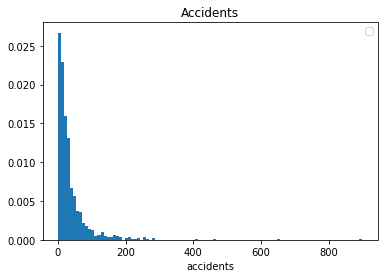

In [10]:
plt.hist(accidents, density=True, bins=100)
plt.title('Accidents')
plt.xlabel('accidents')
plt.legend()
plt.show()

### Posterior predictive distribution

In [11]:
model_2 = CmdStanModel(stan_file='code_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [12]:
data_fit = {'N': len(df), 'miles': df['Miles centered'].values, 'accidents': df['Fatal accidents'].values}
fit = model_2.sample(data=data_fit, seed=2404)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [13]:
fit_df = fit.draws_pd()
fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,510.104,0.864750,0.929307,2.0,3.0,0.0,-510.030,3.28343,-0.056539,29.6123,28.8896,27.7262,27.0235,26.5195,26.1932,26.4252,25.9133,24.1998,24.6500
1,511.908,0.982219,0.929307,1.0,3.0,0.0,-510.166,3.18809,-0.025842,25.4311,25.1455,24.6775,24.3897,24.1807,24.0442,24.1413,23.9264,23.1899,23.3861
2,511.370,0.937583,0.929307,2.0,3.0,0.0,-511.348,3.13019,0.028115,21.7172,21.9856,22.4396,22.7279,22.9417,23.0834,22.9824,23.2070,24.0101,23.7910
3,511.326,0.991654,0.929307,1.0,1.0,0.0,-511.225,3.12732,0.029204,21.6111,21.8887,22.3584,22.6568,22.8782,23.0250,22.9204,23.1531,23.9859,23.7586
4,509.045,0.785981,0.929307,2.0,3.0,0.0,-508.413,3.31563,0.013295,26.8695,27.0261,27.2886,27.4538,27.5756,27.6560,27.5987,27.7260,28.1756,28.0537


In [14]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_df.loc[:, "lambda[1]":"lambda[10]"]

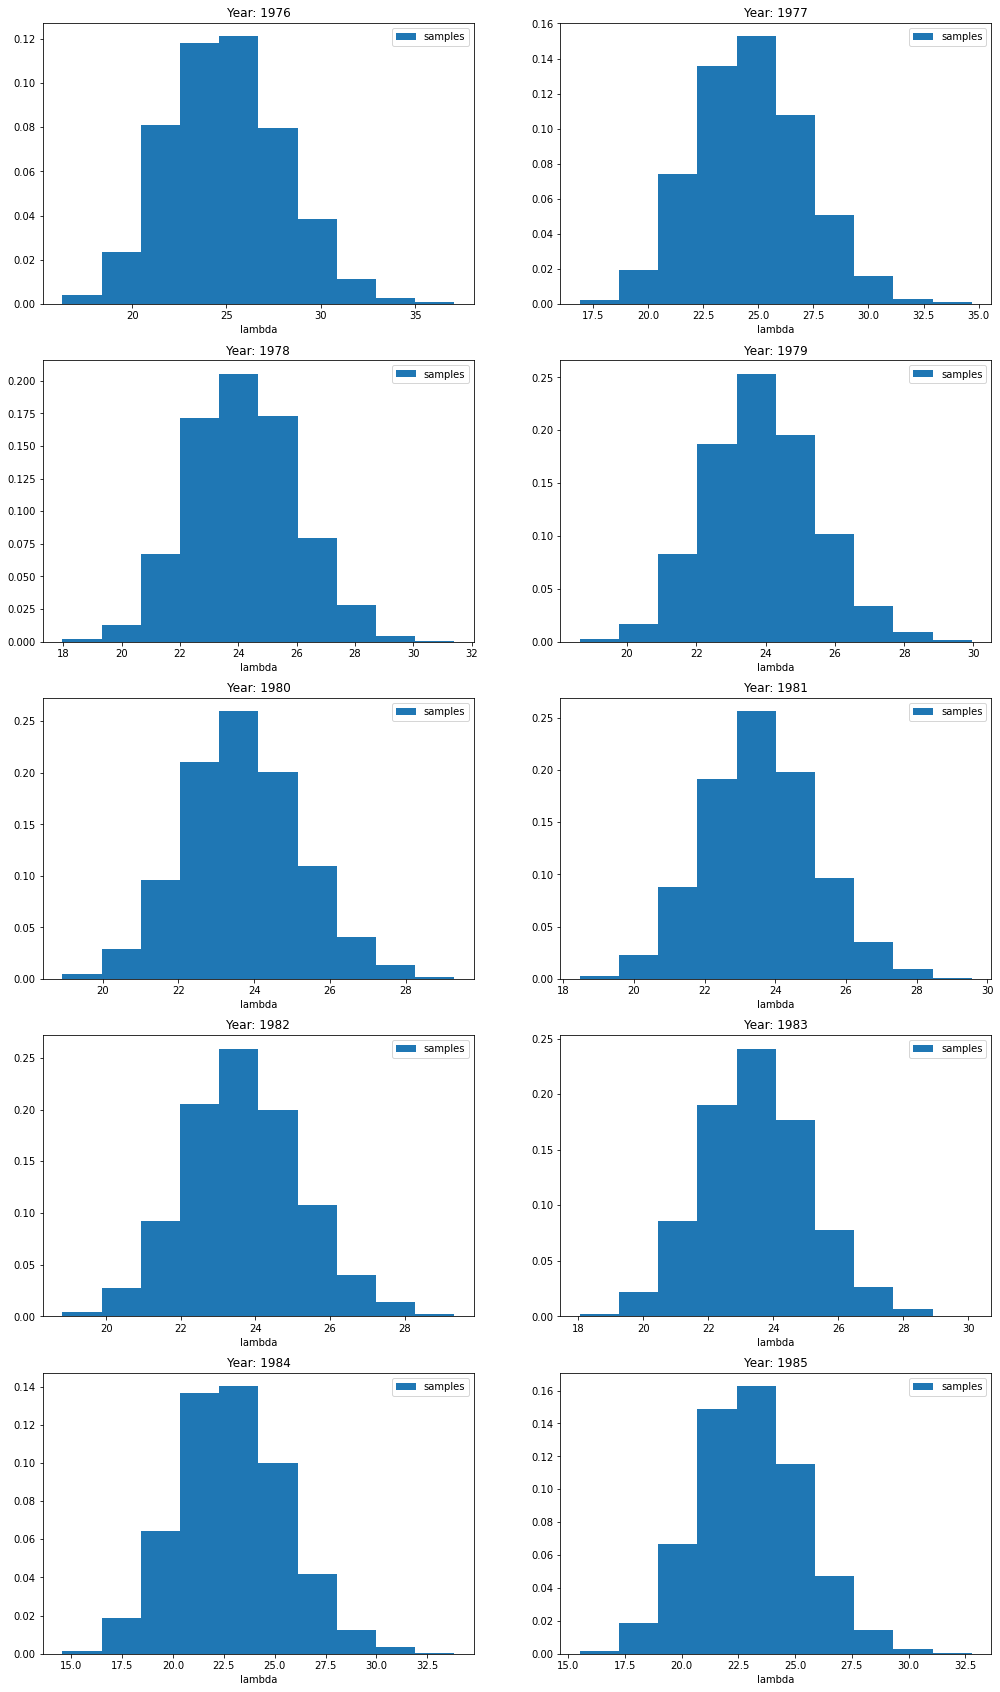

In [15]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(17, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

### Posterior predictive distribution for each year

In [16]:
model_3 = CmdStanModel(stan_file='code_3.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [17]:
fit_2 = model_3.sample(data=data_fit, seed=2404)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [18]:
fit_2_df = fit_2.draws_pd()
fit_2_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,514.596,0.969325,0.464245,3.0,7.0,0.0,-510.313,3.82000,4.02742,3.80013,...,19.6604,29.5025,32.6984,42.4670,22.1696,20.8403,23.3678,22.7794,18.2079,17.2708
1,515.109,0.894373,0.464245,3.0,7.0,0.0,-507.848,4.09019,3.60162,3.67456,...,28.3869,20.7573,29.9004,23.7191,17.0984,24.5993,21.1023,20.3242,14.8170,21.7969
2,516.351,0.947891,0.464245,3.0,7.0,0.0,-511.205,3.67537,3.88476,3.68872,...,19.9635,28.9054,31.0431,32.4333,25.6082,15.7896,26.3618,20.1219,16.7227,21.0999
3,512.264,0.815728,0.464245,3.0,7.0,0.0,-509.371,4.26303,3.99382,3.28684,...,26.6593,25.6629,18.5887,23.9180,23.5927,18.1364,31.8235,16.9638,20.0089,22.5097
4,516.686,0.988515,0.464245,3.0,7.0,0.0,-510.116,4.00466,3.89707,3.78688,...,24.9093,26.9462,32.8977,32.1774,25.6524,19.9667,21.7293,22.8164,19.7771,18.6871


In [19]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_2_df.loc[:, "lambda[1]":"lambda[10]"]

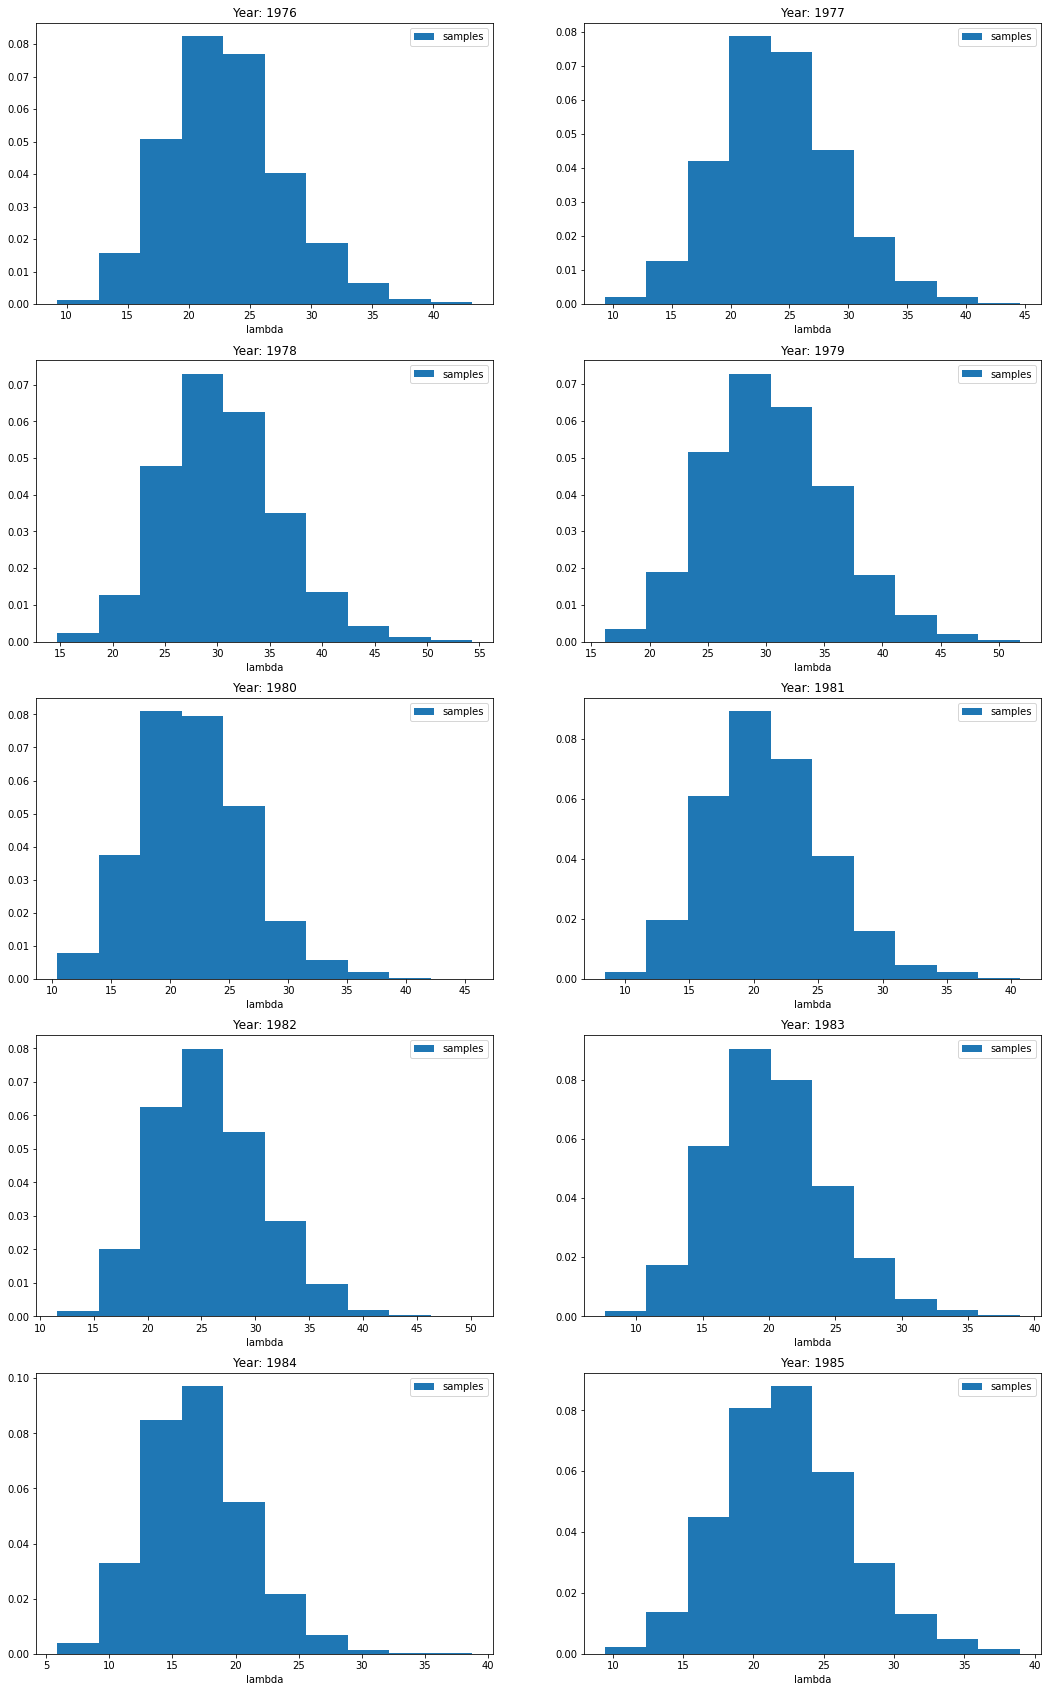

In [20]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()